In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/alexeygrigorev/datasets/master/car_fuel_efficiency.csv")

In [4]:
df = df.fillna(0)

In [5]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.fuel_efficiency_mpg.values
y_val = df_val.fuel_efficiency_mpg.values
y_test = df_test.fuel_efficiency_mpg.values

del df_train['fuel_efficiency_mpg']
del df_val['fuel_efficiency_mpg']
del df_test['fuel_efficiency_mpg']

In [6]:
train_dicts = df_train.to_dict(orient='records')
dv = DictVectorizer(sparse=True)
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val.to_dict(orient='records')
X_val = dv.transform(val_dicts)

## Question 1

In [7]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text

In [8]:
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1)

In [9]:
df.columns

Index(['engine_displacement', 'num_cylinders', 'horsepower', 'vehicle_weight',
       'acceleration', 'model_year', 'origin', 'fuel_type', 'drivetrain',
       'num_doors', 'fuel_efficiency_mpg'],
      dtype='object')

In [10]:
print(export_text(dt, feature_names=dv.feature_names_))

|--- vehicle_weight <= 3022.11
|   |--- value: [16.88]
|--- vehicle_weight >  3022.11
|   |--- value: [12.94]



Which feature is used for splitting the data?


## Question 2

In [12]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error

In [13]:
rf = RandomForestRegressor(
    n_estimators=10,
    random_state=1,
    n_jobs=-1
)

rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

In [14]:
y_pred = rf.predict(X_val)
root_mean_squared_error(y_val, y_pred)

0.4595777223092726

## Question 3

In [15]:
import matplotlib.pyplot as plt

In [16]:
from tqdm.auto import tqdm

In [18]:
scores = []

for n in tqdm(range(10, 201, 10)):
    rf = RandomForestRegressor(
        n_estimators=n,
        random_state=1,
        n_jobs=-1
    )
    rf.fit(X_train, y_train)
    
    y_pred = rf.predict(X_val)
    score = root_mean_squared_error(y_val, y_pred)
    
    scores.append((n, score))

df_scores = pd.DataFrame(scores, columns=['n_estimators', 'rmse'])

  0%|          | 0/20 [00:00<?, ?it/s]

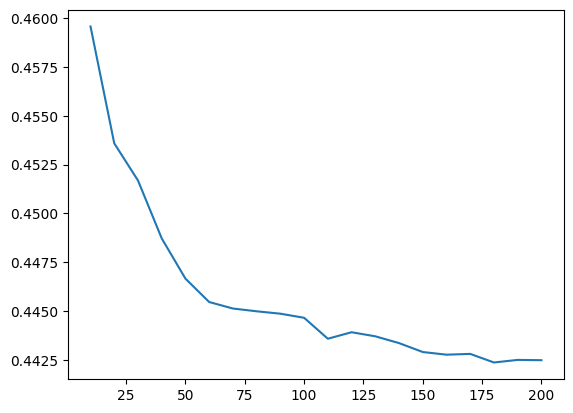

In [19]:
#plt.plot(df_scores.n_estimators, df_scores.rmse)
plt.plot(df_scores.n_estimators, df_scores.rmse)

plt.show()

After which value of `n_estimators` does RMSE stop improving?

- 10
- 25
- 80
- 200

We can use `warm_start=True` to train faster. In this case, we train only additional 10 new trees each time, not the entire ensemble from scratch like previously

```
warm_start : bool, default=False
    When set to ``True``, reuse the solution of the previous call to fit
    and add more estimators to the ensemble, otherwise, just fit a whole
    new forest. See :term:`the Glossary <warm_start>`.
```

In [20]:
scores = []

rf = RandomForestRegressor(
    n_estimators=1,
    random_state=1,
    n_jobs=-1,
    warm_start=True,
)

for n in tqdm(range(10, 201, 10)):
    rf.n_estimators = n
    rf.fit(X_train, y_train)
    
    y_pred = rf.predict(X_val)
    score = root_mean_squared_error(y_val, y_pred)
    
    scores.append((n, score))

df_scores = pd.DataFrame(scores, columns=['n_estimators', 'rmse'])

  0%|          | 0/20 [00:00<?, ?it/s]

It's 7 seconds instead of 56 now

## Question 4

In [21]:
scores = []

for d in tqdm([10, 15, 20, 25]):
    rf = RandomForestRegressor(
        n_estimators=0,
        max_depth=d,
        random_state=1,
        n_jobs=-1,
        warm_start=True
    )

    for n in tqdm(range(10, 201, 10)):
        rf.n_estimators = n
        rf.fit(X_train, y_train)

        y_pred = rf.predict(X_val)
        score = root_mean_squared_error(y_val, y_pred)

        scores.append((d, n, score))

columns = ['max_depth', 'n_estimators', 'rmse']
df_scores = pd.DataFrame(scores, columns=columns)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

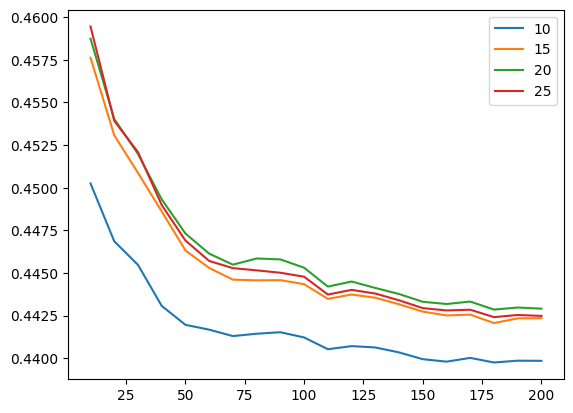

In [22]:
for d in [10, 15, 20, 25]:
    df_subset = df_scores[df_scores.max_depth == d]
    plt.plot(df_subset.n_estimators, df_subset.rmse, label=d)

plt.legend()
plt.show()

What's the best `max_depth`:

* **10**
* 15
* 20
* 25

## Question 5

In [25]:
rf = RandomForestRegressor(
    n_estimators=10,
    max_depth=20,
    random_state=1,
    n_jobs=-1
)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, n_estimators=10, n_jobs=-1, random_state=1)

In [26]:
df_importances = pd.DataFrame()
df_importances['feature'] = dv.feature_names_
df_importances['importance'] = rf.feature_importances_
df_importances.sort_values(by='importance', ascending=False).head()

,feature,importance
13,vehicle_weight,0.959150
6,horsepower,0.015998
0,acceleration,0.011480
3,engine_displacement,0.003273
7,model_year,0.003212


What's the most important feature (among these 4)? 

* **`study_hours_per_week`**
* `attendance_rate`
* `distance_to_school`
* `teacher_quality`


## Question 6

In [27]:
import xgboost as xgb

In [28]:
features = dv.feature_names_
features = [f.replace('<', 'less ') for f in features]
features

['acceleration',
 'drivetrain=All-wheel drive',
 'drivetrain=Front-wheel drive',
 'engine_displacement',
 'fuel_type=Diesel',
 'fuel_type=Gasoline',
 'horsepower',
 'model_year',
 'num_cylinders',
 'num_doors',
 'origin=Asia',
 'origin=Europe',
 'origin=USA',
 'vehicle_weight']

In [29]:
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [30]:
watchlist = [(dtrain, 'train'), (dval, 'val')]
scores = {}

In [31]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_auc', 'val_auc']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [32]:
%%capture output_03

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                  verbose_eval=5, evals=watchlist)

In [33]:
scores['eta=0.3'] = parse_xgb_output(output_03)

In [34]:
%%capture output_01

xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                  verbose_eval=5, evals=watchlist)

In [35]:
scores['eta=0.1'] = parse_xgb_output(output_01)

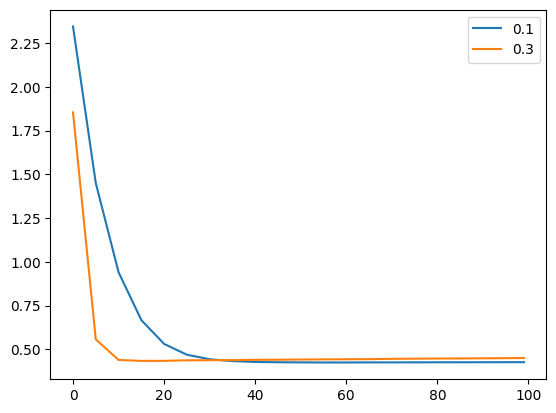

In [36]:
plt.plot(scores['eta=0.1'].num_iter, scores['eta=0.1'].val_auc,
        label='0.1')
plt.plot(scores['eta=0.3'].num_iter, scores['eta=0.3'].val_auc,
        label='0.3')
plt.legend()
plt.show()

Which eta leads to the best RMSE score on the validation dataset?

* 0.3
* **0.1**
* Both give equal value

Note that rounding doesn't change the answer:

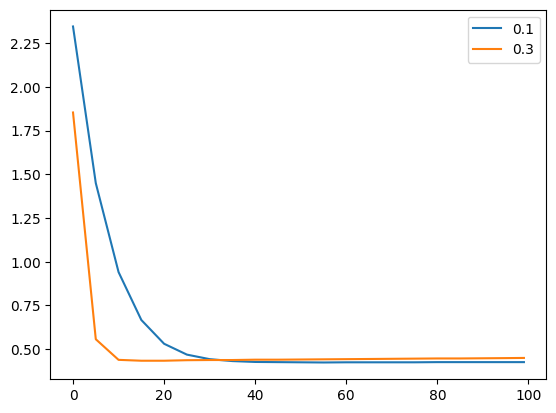

In [37]:
plt.plot(scores['eta=0.1'].num_iter, scores['eta=0.1'].val_auc.round(3),
        label='0.1')
plt.plot(scores['eta=0.3'].num_iter, scores['eta=0.3'].val_auc.round(3),
        label='0.3')
plt.legend()
plt.show()